In [1]:
import os
import cv2
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import imgaug.augmenters as iaa

# Set up directories for male and female images
male_dir = "E:\python files\Male"
female_dir = "E:\python files\Female"

# Preprocessing function to resize and preprocess images
def preprocess(img):
    img = cv2.resize(img, (100, 100))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.flatten()
    return img

# Load male and female images into arrays and preprocess them
male_images = []
for img_file in os.listdir(male_dir):
    img = cv2.imread(os.path.join(male_dir, img_file))
    img = preprocess(img)
    male_images.append(img)

female_images = []
for img_file in os.listdir(female_dir):
    img = cv2.imread(os.path.join(female_dir, img_file))
    img = preprocess(img)
    female_images.append(img)

# Combine male and female images into a single dataset and labels array
X = np.concatenate((male_images, female_images))
y = np.concatenate((np.ones(len(male_images)), np.zeros(len(female_images))))

# Apply image augmentations to the dataset
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)), # blur images with a sigma of 0 to 3.0
    iaa.Affine(rotate=(-45, 45)), # rotate images by -45 to 45 degrees
    iaa.LinearContrast((0.75, 1.5)), # adjust contrast of images
    iaa.Multiply((0.8, 1.2)) # multiply pixel values with random values between 0.8 to 1.2
])

X_augmented = seq.augment_images(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y, test_size=0.2, random_state=42)

# Encode labels as integers
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Train SVM model on training data
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

# Test SVM model on testing data and evaluate accuracy
y_pred = clf.predict(X_test)




Epoch 1/100


10/10 [==============================] - 1s 22ms/step - loss: 0.9988 - accuracy: 0.7201 - val_loss: 0.1191 - val_accuracy: 0.9697
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 0.5667 - accuracy: 0.8464 - val_loss: 0.2855 - val_accuracy: 0.9394
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 0.1980 - accuracy: 0.9283 - val_loss: 0.3170 - val_accuracy: 0.9091
Epoch 4/100
10/10 [==============================] - 0s 7ms/step - loss: 0.2727 - accuracy: 0.9386 - val_loss: 0.1257 - val_accuracy: 0.9697
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 0.1513 - accuracy: 0.9556 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 0.1139 - accuracy: 0.9625 - val_loss: 0.0187 - val_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0597 - accuracy: 0.9863 - val_loss: 0.0286 - val_accuracy: 0.9697
Epoch 8

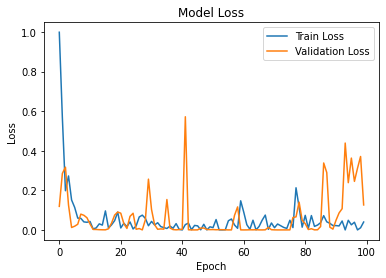

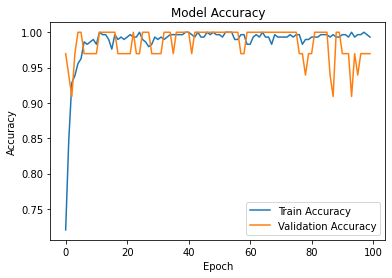

5/5 [==============================] - 0s 1ms/step


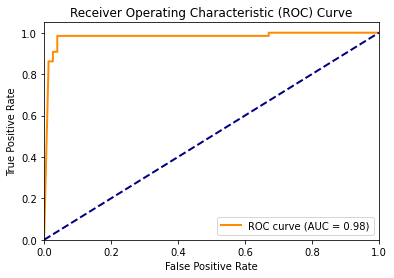

In [2]:
import tensorflow_quantum as tfq
import tensorflow as tf

classical_cnn_model = tf.keras.applications.MobileNetV2(input_shape=(28, 28, 1), include_top=False)
classical_cnn_model.trainable = False

def create_qcnn_model():
    qconv_layer = tfq.layers.PQC(X_train) 
    qpool_layer = tfq.layers.PQC(X_train)
    
    model = tf.keras.models.Sequential([
        qconv_layer,
        qpool_layer,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2)  # Output layer for binary classification (male or female)
    ])
    
    return model

# Create the QCNN model
qcnn_model = create_qcnn_model()

# Transfer weights from classical CNN to quantum CNN
for i in range(len(classical_cnn_model.layers)):
    qcnn_model.layers[i].set_weights(classical_cnn_model.layers[i].get_weights())

# Compile the QCNN model
qcnn_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy']);